# Apple Closing Price LSTM RNN Models

In [67]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

In [68]:
# set seeds for max reproducibility

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [69]:
# load the data
aapl = pd.read_csv('aapl.csv')

aapl.Date = pd.to_datetime(aapl.Date)

aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100453,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095213,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088224,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090408,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093029,73449600


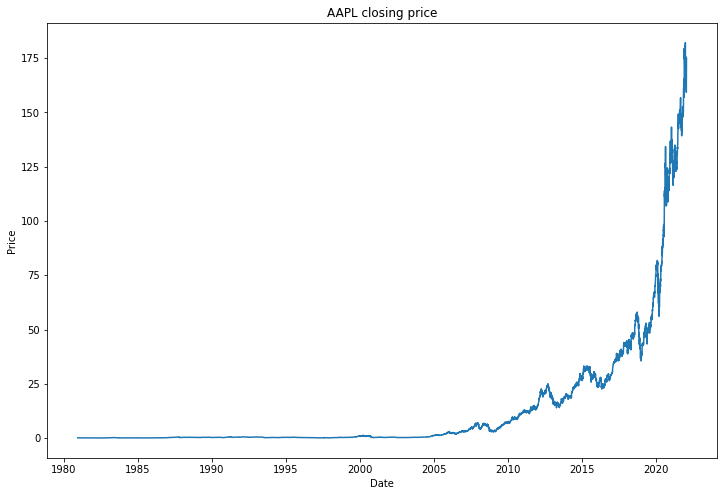

In [70]:
# plot the closing price
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(aapl.Date, aapl['Close'])
ax.set_title('AAPL closing price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

## Create the LSTM model

In [71]:
# center all columns apple

apple_norm = aapl.copy()

dates = apple_norm['Date']

dates = pd.to_datetime(dates)

apple_norm = apple_norm.drop(['Date'], axis=1)

a_scaler = MinMaxScaler(feature_range=(0, 1))

apple_norm = pd.DataFrame(a_scaler.fit_transform(apple_norm), columns=apple_norm.columns)

apple_norm.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.000431,0.000433,0.000443,0.000435,0.000341,0.063198
1,0.000397,0.000397,0.000405,0.000399,0.000312,0.023699
2,0.000348,0.000348,0.000355,0.000350,0.000274,0.014246
3,0.000361,0.000363,0.000371,0.000365,0.000286,0.011647
4,0.000379,0.000381,0.000390,0.000383,0.000300,0.009897


In [72]:
n_inputs = 10
n_predictions = 1
batch_size = 32

In [73]:
# training and testing data

train_data = apple_norm[:round(len(apple_norm["Open"])*0.8)]
# valid_data = apple_norm[round(len(apple_norm["Open"])*0.6):]
test_data = apple_norm[round(len(apple_norm["Open"])*0.8):]


In [74]:

# shape training data for LSTM
n_inputs = 10
n_predictions = 1
batch_size = 32

# save test data for later


X_train = []
y_train = []

for i in range(n_inputs, len(train_data) - n_predictions+1):
    X_train.append(train_data.iloc[i-n_inputs:i , 0:6])
    y_train.append(train_data.iloc[i+n_predictions - 1 : i + n_predictions, 3])


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = keras.backend.cast_to_floatx(X_train)
# y_train = keras.backend.cast_to_floatx(y_train)

print(X_train.shape)
print(y_train.shape)

(8288, 10, 6)
(8288, 1)


In [75]:
def preprocess_lstm(df,n_inputs=10, n_predictions=1, n_features=6):

    X_train = []
    y_train = []


    for i in range(n_inputs, len(df) - n_predictions+1):
        X_train.append(df.iloc[i-n_inputs:i , 0:n_features])
        y_train.append(df["Close"][i : i + n_predictions])


    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train


In [76]:
# build LSTM model

model_lstm = Sequential()

model_lstm.add(LSTM(units=64, 
                    return_sequences=False,
                    input_shape=(10, 6)
                    ))

model_lstm.add(Dense(units=1))


model_lstm.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")


In [77]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [78]:
# early stopping
early_s = EarlyStopping(monitor='val_loss',patience=15)

In [79]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=6)
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_s], verbose=0)

2022-02-28 11:03:18.674764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:03:18.742463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:03:18.862104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:03:21.530458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:03:21.559088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


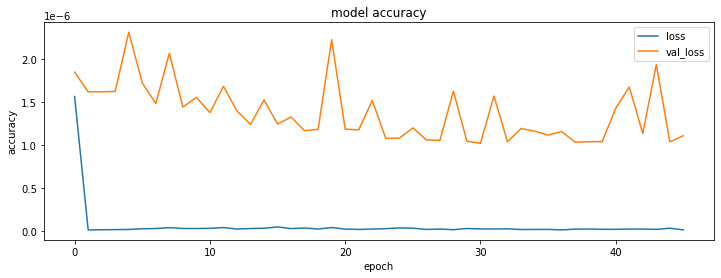

In [80]:
fig, ax = plt.subplots( figsize=(12, 4))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

In [81]:
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=6)

y_predicted = model_lstm.predict(X_testing)

2022-02-28 11:05:02.549520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:05:02.567498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


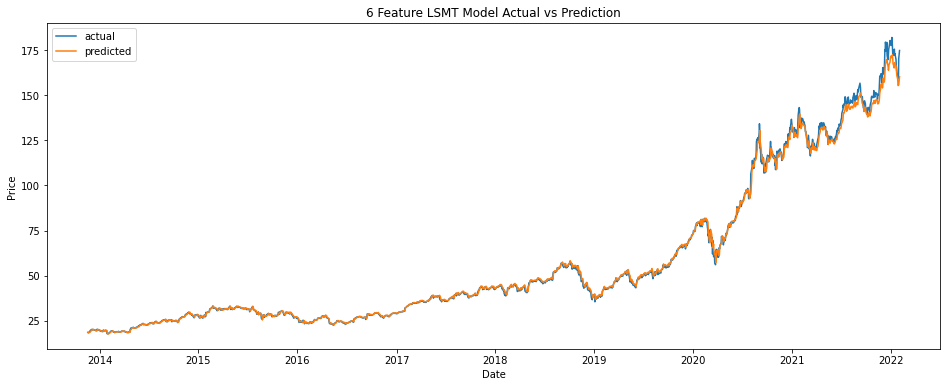

In [82]:
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title('6 Feature LSMT Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()

## Model Variations Question B

### Simple RNN with only Close Price as Feature

In [83]:
# build RNN model

model_rnn_single = Sequential()

model_rnn_single.add(SimpleRNN(units=64, 
                    return_sequences=False,
                    input_shape=(10, 1)
                    ))

model_rnn_single.add(Dense(units=1))


model_rnn_single.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")


In [84]:
X_train, y_train = preprocess_lstm(pd.DataFrame(train_data["Close"]), n_inputs=10, n_predictions=1, n_features=1)

In [85]:
early_s = EarlyStopping(monitor='val_loss',patience=5)

In [86]:
history = model_rnn_single.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)

2022-02-28 11:05:03.845275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:05:07.113098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


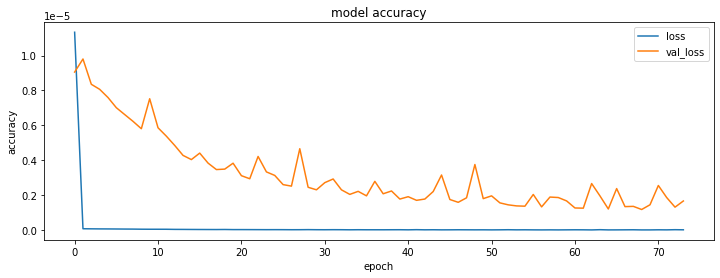

In [87]:
fig, ax = plt.subplots( figsize=(12, 4))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

2022-02-28 11:08:49.840605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


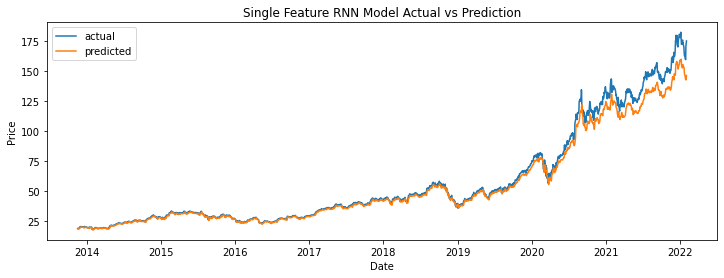

In [88]:
# plot the predicted and actual values

X_testing, y_testing = preprocess_lstm(pd.DataFrame(test_data["Close"]), n_inputs=10, n_predictions=1, n_features=1)
y_predicted = model_rnn_single.predict(X_testing)
# Rescale the predicted values
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(12, 4))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title('Single Feature RNN Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()



### Multi Feature RNN

2022-02-28 11:08:51.307519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:08:54.787585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


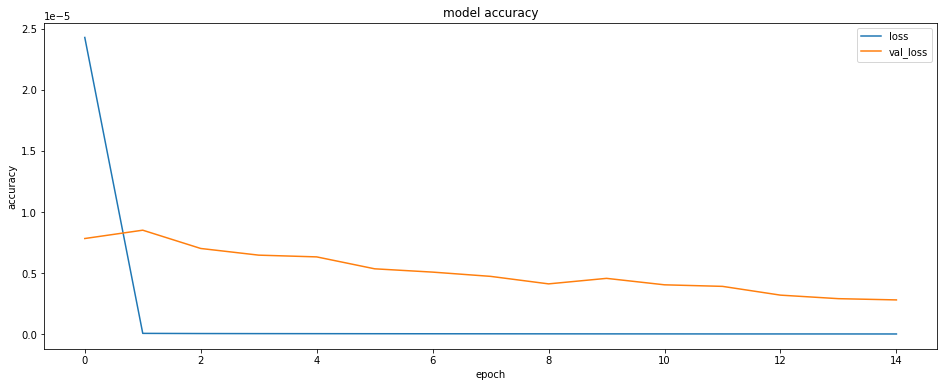

In [89]:
# build RNN model

n_features = 5

model_rnn_multi = Sequential()

model_rnn_multi.add(SimpleRNN(units=64, 
                    return_sequences=False,
                    input_shape=(10, n_features)
                    ))

model_rnn_multi.add(Dense(units=1))


model_rnn_multi.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")

X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=n_features)
early_s = EarlyStopping(monitor='val_loss',patience=3)
history_rnn_multi = model_rnn_multi.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)
fig, ax = plt.subplots( figsize=(16, 6))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history_rnn_multi.history['loss'], label = 'loss')
ax.plot(history_rnn_multi.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()


In [90]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=n_features)

In [91]:
early_s = EarlyStopping(monitor='val_loss',patience=3)

In [92]:
history_rnn_multi = model_rnn_multi.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)

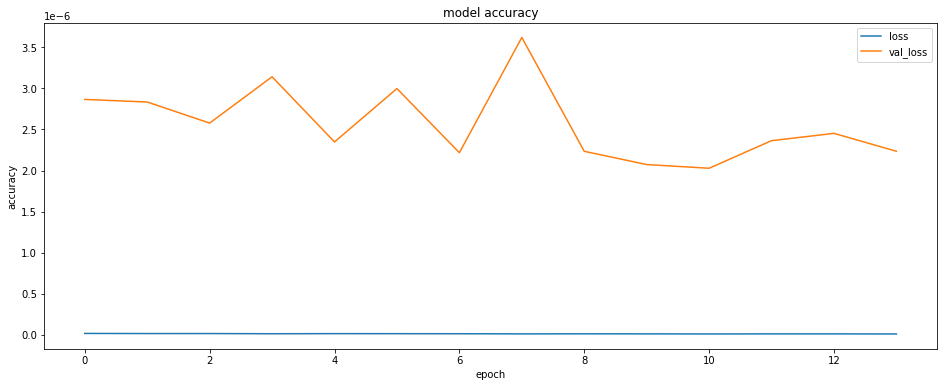

In [93]:
fig, ax = plt.subplots( figsize=(16, 6))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history_rnn_multi.history['loss'], label = 'loss')
ax.plot(history_rnn_multi.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

2022-02-28 11:10:24.570808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


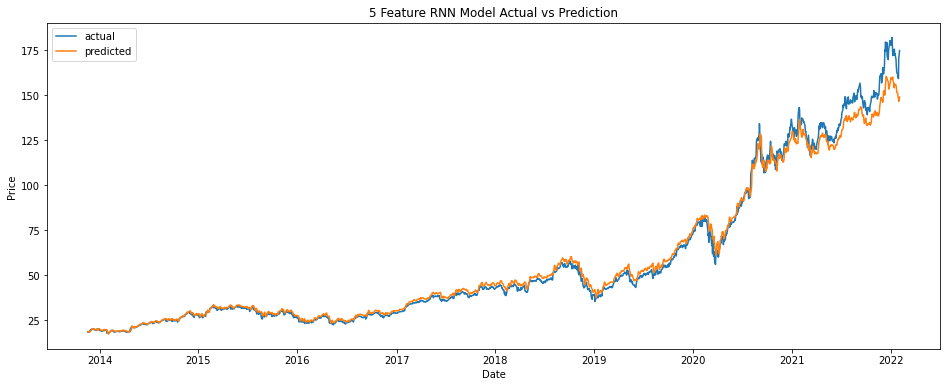

In [94]:
# plot the predicted and actual values
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=5)
y_predicted = model_rnn_multi.predict(X_testing)
# Rescale the predicted values
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title(f'{n_features} Feature RNN Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()



## LSTM Hyperparameter Tuning

In [95]:
import keras_tuner as kt

In [96]:
# create model for 1 input layer 

def model_builder(hp):

    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=448, step=32), 
                    return_sequences=False,
                    input_shape=(n_input, 6)))
    model.add(Dense(units=1))
    model.compile(optimizer='sgd', 
                    loss='logcosh',
                    metrics= "mse")

    return model

In [97]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Code for input size and Layer size optimisation

It is commented out as it takes very long to run. It works, if someone has the patience for it. 

Will present a shorter hyper parameter tuning after.

In [98]:
# takes over 200 minutes to run on laptop
# hyper_params = pd.DataFrame(columns=['inputs','units', 'val_loss'])

# for i in range(10,30):
#     n_input = i
#     tuner = kt.Hyperband(model_builder,
#                         objective='val_mse',
#                         max_epochs=50,
#                         directory='models',
#                         project_name='lstm_tuner',
#                         overwrite=True)

#     X_train, y_train = preprocess_lstm(train_data, n_inputs=i, n_predictions=1, n_features=6)
#     tuner.search(X_train, y_train, epochs=i, batch_size=100, validation_split=0.2)
#     tuner.results_summary()
#     # tuner.plot()
#     best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#     # print(best_hps.get_details())
#     best_model = tuner.hypermodel.build(best_hps)
#     history_best = best_model.fit(X_train,y_train,epochs=50,batch_size=50,validation_split=0.3,callbacks=[stop_early])
#     hyper_params.loc[i] = [i,best_hps.get('units'),min(history_best.history['val_loss'])]




In [99]:
# # Shorter version of previous code still 72 minutes
# hyper_params = pd.DataFrame(columns=['inputs','units', 'val_loss'])

# input_size = [10, 15, 20, 24, 25, 30]

# for i in input_size:
#     n_input = i
#     tuner = kt.Hyperband(model_builder,
#                         objective='val_mse',
#                         max_epochs=20,
#                         directory='lstm_tuner_models',
#                         project_name='lstm_tuner',
#                         overwrite=True)

#     X_train, y_train = preprocess_lstm(train_data, n_inputs=i, n_predictions=1, n_features=6)
#     tuner.search(X_train, y_train, epochs=i, batch_size=100, validation_split=0.2)
#     tuner.results_summary()
#     # tuner.plot()
#     best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#     # print(best_hps.get_details())
#     best_model = tuner.hypermodel.build(best_hps)
#     history_best = best_model.fit(X_train,y_train,epochs=50,batch_size=50,validation_split=0.3,callbacks=[stop_early])
#     hyper_params.loc[i] = [i,best_hps.get('units'),min(history_best.history['val_loss'])]

# order by val_loss

# hyper_params.sort_values(by=['val_loss'], inplace=True)
# hyper_params


### Hyperparameter Tuning LSTM and RNN with GridSearch optimising Neuron numbers and Optimisers

In [100]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [101]:
def create_lstm_model(optimiser, neurons):
    model = Sequential()
    model.add(LSTM(units=neurons, 
                    return_sequences=False,
                    input_shape=(15, 6)))

    model.add(Dense(units=1))
    model.compile(optimizer=optimiser, 
                    loss='logcosh',
                    metrics= "mse")
    return model

In [102]:
def create_rnn_model(optimiser, neurons):
    # build RNN model

    model_rnn_single = Sequential()

    model_rnn_single.add(SimpleRNN(units=neurons, 
                    return_sequences=False,
                    input_shape=(15, 6)
                    ))

    model_rnn_single.add(Dense(units=1))


    model_rnn_single.compile(optimizer=optimiser, 
                    loss='logcosh',
                    metrics= "mse")
    return model_rnn_single

    

In [103]:
model_lstm = KerasRegressor(build_fn=create_lstm_model, verbose=0, epochs = 10, batch_size=100)

model_rnn = KerasRegressor(build_fn=create_rnn_model, verbose=0, epochs = 10, batch_size=100)


In [104]:
optimiser = ['adam', 'sgd',"adagrad", "adadelta", "rmsprop"] # all options
optimiser = ['adam', 'sgd'] # for reduced runtime time

neurons = [32, 64, 128]

In [105]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=15, n_predictions=1, n_features=6)

In [106]:
param_grid = dict(optimiser=optimiser, neurons=neurons)

grid_lstm = GridSearchCV(estimator=model_lstm, param_grid=param_grid, error_score='raise', verbose=0, cv=2)
grid_rnn = GridSearchCV(estimator=model_rnn, param_grid=param_grid, error_score='raise', verbose=0, cv=2)


In [107]:

grid_lstm.fit(X_train, y_train, verbose=0)

2022-02-28 11:10:26.783980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:26.849201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:26.968023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:32.434539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:32.459843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:33.238506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:10:33.301291: I tensorflow/core/grappler/optimizers/cust

GridSearchCV(cv=2, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x286e75190>,
             param_grid={'neurons': [32, 64, 128],
                         'optimiser': ['adam', 'sgd']})

In [108]:
grid_rnn.fit(X_train, y_train, verbose=0)

2022-02-28 11:12:01.476248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:12:34.059884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:12:35.022272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:13:08.197530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:13:09.119404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:13:40.869869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:13:41.810698: I tensorflow/core/grappler/optimizers/cust

GridSearchCV(cv=2, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x286e75700>,
             param_grid={'neurons': [32, 64, 128],
                         'optimiser': ['adam', 'sgd']})

In [109]:
# output best models from grid search

print("LSTM Best params {} with Mean Square Root Error {}".format(grid_lstm.best_params_, grid_lstm.best_score_))
print("RNN Best model {} with Mean Square Root Error {}".format(grid_rnn.best_params_, grid_rnn.best_score_))

LSTM Best params {'neurons': 128, 'optimiser': 'adam'} with Mean Square Root Error -3.169875917308218e-07
RNN Best model {'neurons': 128, 'optimiser': 'adam'} with Mean Square Root Error -3.5331660219739547e-06


## Predicting 2 days forward from 7 Days of Data

In [110]:
# create model to predict future values

def create_2day_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=192, max_value=252, step=32),
                    return_sequences=True,
                    input_shape=(7, 6)))
    model.add(LSTM(units=hp.Int('units', min_value=192, max_value=252, step=32),
                    return_sequences=False,
                    input_shape=(7, 6)))
    model.add(Dense(units= hp.Int('dense', min_value=10, max_value=50, step = 10),
                    activation='linear'))
    model.add(Dense(units= hp.Int('dense', min_value=10, max_value=50, step = 10),
                    activation='linear'))
                    
    # model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(units=2))
    model.compile(optimizer= "adam",
                    loss='logcosh',
                    metrics= "mse")
    
    return model

In [111]:
tuner_2d_lstm = kt.Hyperband(create_2day_model,
                            objective='val_mse',
                            max_epochs=20,
                            directory='lstm_2d_tuner_models',
                            project_name='lstm_tuner',
                            overwrite=True
                            )


In [112]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=7, n_predictions=2, n_features=6)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

tuner_2d_lstm.search(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

2022-02-28 11:19:50.935681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:51.056616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:51.126686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:51.293124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:51.414981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:53.286827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:19:53.328353: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


In [113]:
best_hps=tuner_2d_lstm.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layers
layers are {best_hps.get('units')} and the optimal units in the dense layer {best_hps.get('dense')}.
""")



The hyperparameter search is complete. The optimal number of units in the LSTM layers
layers are 192 and the optimal units in the dense layer 40.



In [114]:
# for quick testing

# lstm_2d = Sequential()
# lstm_2d.add(LSTM(units=252,
#         return_sequences=True,
#         input_shape=(7, 6)))
# lstm_2d.add(LSTM(units=252,
#         return_sequences=False,
#         input_shape=(7, 5)))
# lstm_2d.add(Dense(units= 30,
#         activation='linear'))

# lstm_2d.add(Dense(units= 10,
#         activation='linear'))
        
# # lstm_2d.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

# lstm_2d.add(Dense(units=2))
# lstm_2d.compile(optimizer= "adam",
#         loss='logcosh',
#         metrics= "mse")

In [115]:
lstm_2d = tuner_2d_lstm.hypermodel.build(best_hps) # comment out line to use the non hypertuned model
X_train, y_train = preprocess_lstm(train_data, n_inputs=7, n_predictions=2, n_features=6)

lstm_2d.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

lstm_2d.fit(X_train, y_train, epochs=60, batch_size=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 192)            152832    
_________________________________________________________________
lstm_3 (LSTM)                (None, 192)               295680    
_________________________________________________________________
dense_3 (Dense)              (None, 40)                7720      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 82        
Total params: 457,954
Trainable params: 457,954
Non-trainable params: 0
_________________________________________________________________


2022-02-28 11:20:40.226884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:40.368127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:40.469517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:40.666053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:40.789939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:42.727002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:20:42.770910: I tensorflow/core/grappler/optimizers/cust

Epoch 00039: early stopping


2022-02-28 11:21:28.928314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:21:28.960694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:21:29.016100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


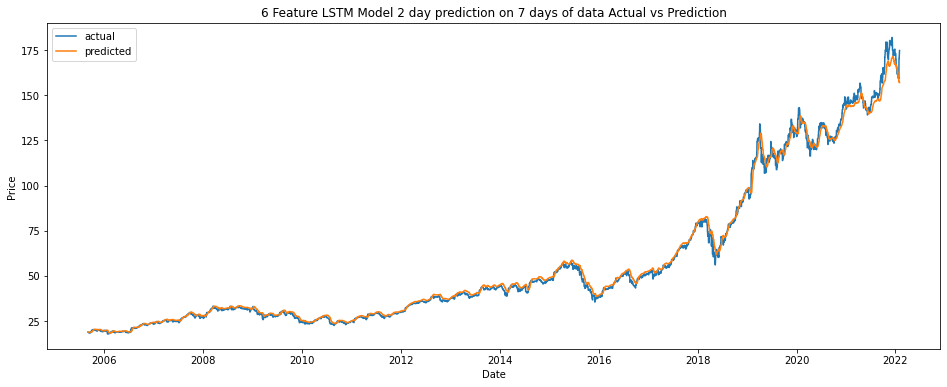

In [116]:
# plot the predicted and actual values
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=7, n_predictions=2, n_features=6)
y_predicted = lstm_2d.predict(X_testing)
# Rescale the predicted values

y_predicted = y_predicted.reshape(-1, 1)
y_testing = y_testing.reshape(-1, 1)

y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(y_testing):],y_testing, label = 'actual')
ax.plot(dates[-len(y_testing):],y_predicted, label = 'predicted')
ax.set_title('6 Feature LSTM Model 2 day prediction on 7 days of data Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()

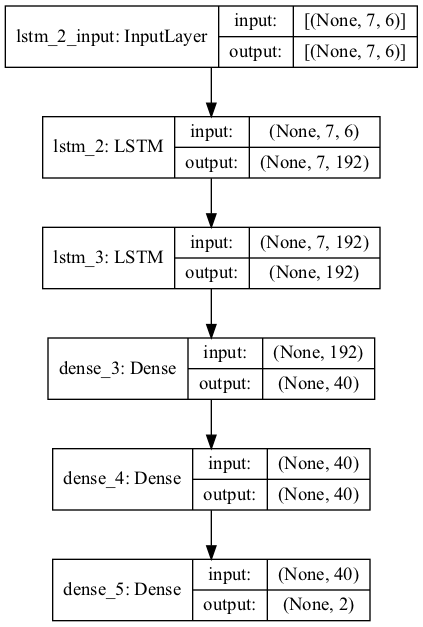

In [117]:
keras.utils.plot_model(lstm_2d,
                       to_file='lstm_2d_model.png',
                       show_shapes=True,
                       show_layer_names=True,
                       )


## CNN model

In [118]:

model_cnn = Sequential()

model_cnn.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 6)))
model_cnn.add(keras.layers.MaxPool1D(pool_size=2))
model_cnn.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(Dense(units=128, activation='relu'))
model_cnn.add(Dropout(rate = 0.15))
model_cnn.add(Dense(units=64, activation='relu'))
model_cnn.add(Dense(units=1))
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [119]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=6)

In [120]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

2022-02-28 11:21:32.303588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-28 11:21:33.091731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


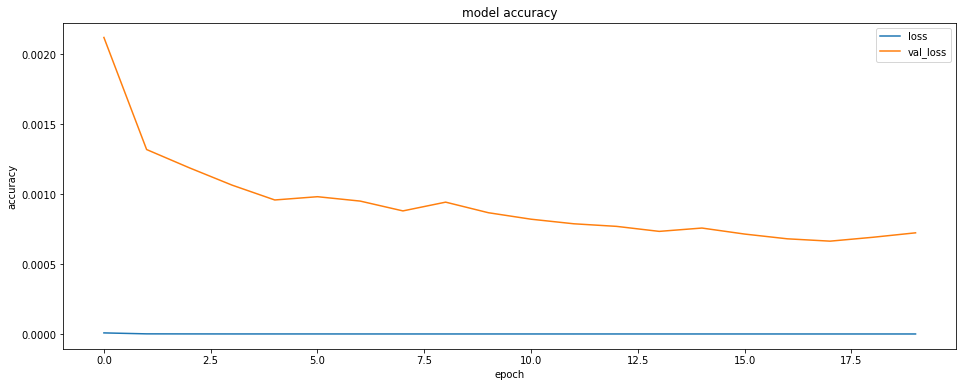

In [121]:


fig, ax = plt.subplots( figsize=(16, 6))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history_cnn.history['loss'], label = 'loss')
ax.plot(history_cnn.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

2022-02-28 11:21:41.298351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


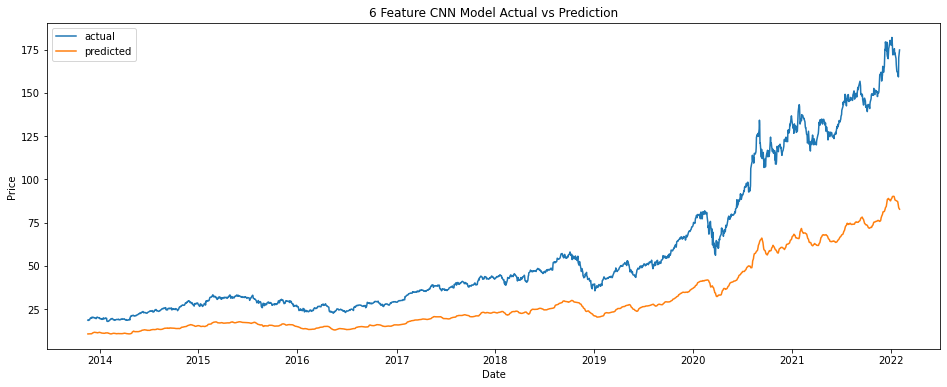

In [122]:
# plot the predicted and actual values
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=6)
y_predicted = model_cnn.predict(X_testing)
# Rescale the predicted values
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title(f'{6} Feature CNN Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()



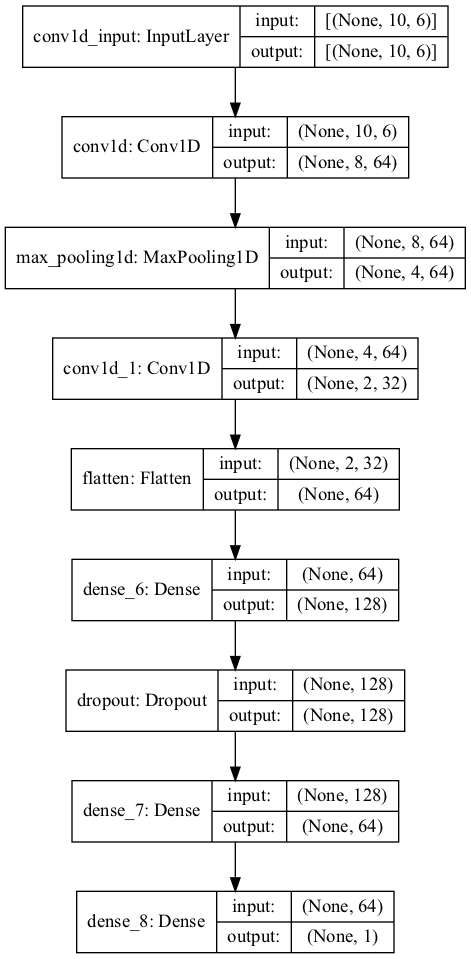

In [123]:
keras.utils.plot_model(model_cnn,
                          to_file='cnn_model.png',
                            show_shapes=True,
                            show_layer_names=True,
                            )